In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kagglejson/'

In [ ]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset

100% 211k/211k [00:00<00:00, 744kB/s]
100% 211k/211k [00:00<00:00, 743kB/s]


 # **APPROACH**

---



* Import libaries
*  Load Dataset
* Analyze the Data
*  Perform EDA
*  Data preperation / Transformation
*  Applying the models
*  Comparing Accuracies
*  Deployment

  





## Importing libraries

---

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Loading the dataset
---

In [ ]:
!unzip sms-spam-collection-dataset.zip

Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


In [ ]:
data = pd.read_csv('/content/spam.csv', encoding= 'ISO-8859-1', encoding_errors = 'strict')

In [ ]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
data.shape

(5572, 5)

## Analyzing the data
---

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB




> * We see that cols 2,3 and 4 are unnecesary and contains a lot of null values
> * We will drop them off later





In [ ]:
data.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [ ]:
data['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64



> * We see that the data is imblanaced



## Performing EDA
---

> * We drop the last three columns as they are unnecessary and have a lot of null values

In [ ]:
data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [ ]:
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


> * Encoding ham and spam using label encoder

In [ ]:
encoder = LabelEncoder()
data['v1'] = encoder.fit_transform(data['v1'])

In [ ]:
data.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


> * Checking and removing duplicates

In [ ]:
data.duplicated().sum()

403

In [ ]:
data = data.drop_duplicates(keep='first')

In [ ]:
data.duplicated().sum()

0

> * Finding the total number of words using tokenization (nltk)

In [ ]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data['words'] = data['v2'].apply(lambda x:len(nltk.word_tokenize(x)))

In [ ]:
data.head()

,v1,v2,words
0,0,"Go until jurong point, crazy.. Available only ...",24
1,0,Ok lar... Joking wif u oni...,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,37
3,0,U dun say so early hor... U c already then say...,13
4,0,"Nah I don't think he goes to usf, he lives aro...",15


> *  Checking data distribution for the number of words for ham and spam

In [ ]:
data[data['v1']==0][['words']].describe()

,words
count,4516.000000
mean,17.123782
std,13.493970
min,1.000000
25%,8.000000
50%,13.000000
75%,22.000000
max,220.000000


In [ ]:
data[data['v1']==1][['words']].describe()

,words
count,653.000000
mean,27.667688
std,7.008418
min,2.000000
25%,25.000000
50%,29.000000
75%,32.000000
max,46.000000


<Axes: xlabel='words', ylabel='Count'>

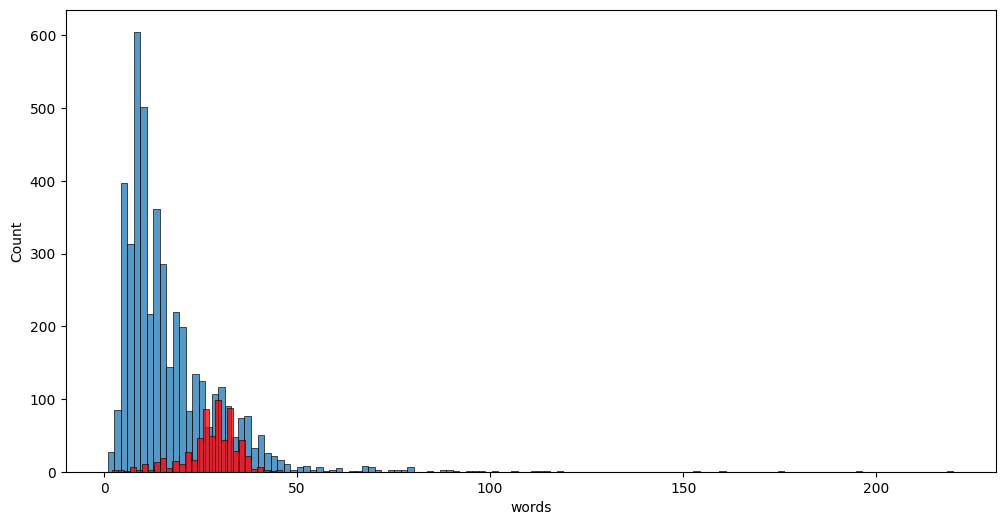

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(data[data['v1'] == 0]['words'])
sns.histplot(data[data['v1'] == 1]['words'],color='red')

> * We see that spam has usually more number of words even tho ham has a larger distribution

## Data Preperation /  Transformation

---

1. Lower case transformation
2. Tokenization
3. Removal of stop words
4. Punctuation and special characters removal
5. Stemming


In [ ]:
ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))


    return " ".join(y)

> * Using the function above we can transform the text

In [ ]:
data['after_transformation'] = data['v2'].apply(transform_text)

In [ ]:
data.head()

,v1,v2,words,after_transformation
0,0,"Go until jurong point, crazy.. Available only ...",24,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,8,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,37,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,13,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",15,nah think goe usf live around though


> * Showing wordcloud of ham and spam data

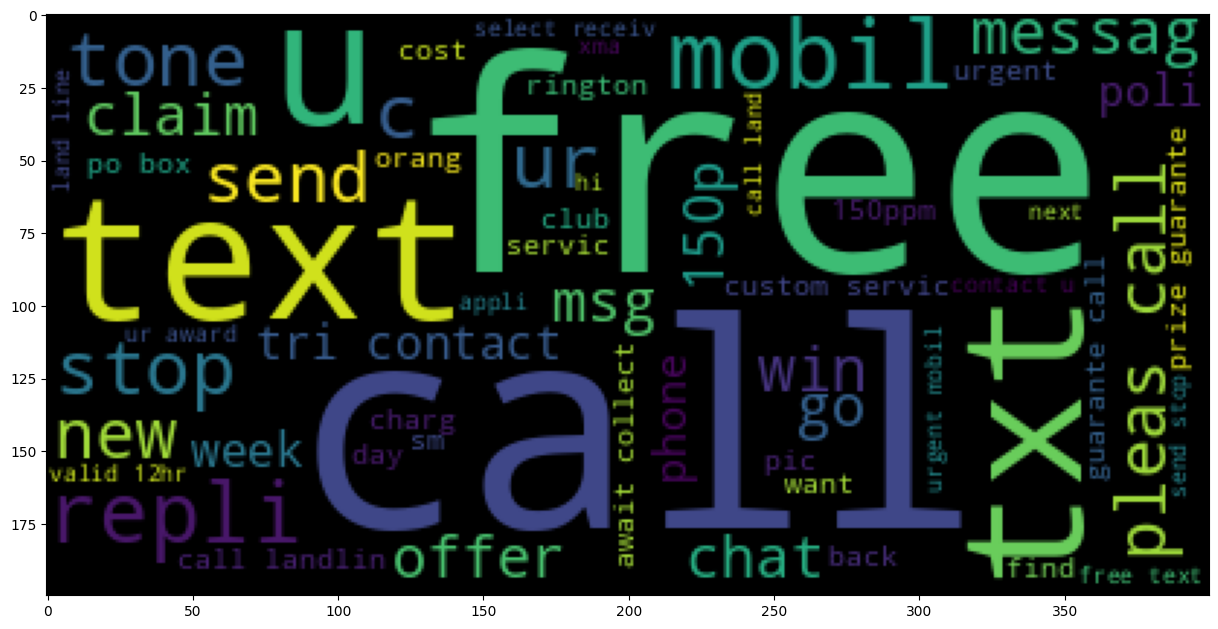

In [ ]:
wc = WordCloud(min_font_size=8)
spam_wc = wc.generate(data[data['v1']==1]['after_transformation'].str.cat(sep=" "))
plt.figure(figsize=(15, 8))
plt.imshow(spam_wc)

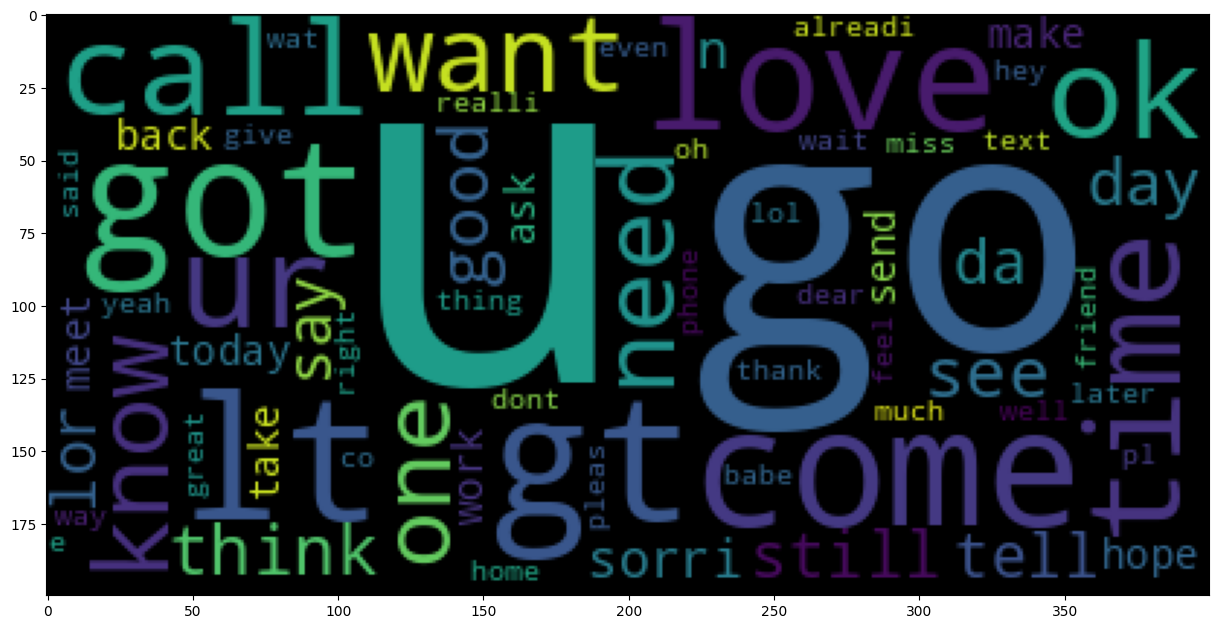

In [ ]:
wc = WordCloud(min_font_size=8)
ham_wc = wc.generate(data[data['v1']==0]['after_transformation'].str.cat(sep=" "))
plt.figure(figsize=(15, 8))
plt.imshow(ham_wc)